<a href="https://colab.research.google.com/github/20402182/CL_Investigation/blob/main/Investigation_into_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## MNIST Dataset

MNIST is a dataset of 60,000, 28x28 greyscale images depicting handwritten digits from 0 to 9. This dataset is small due to its 28x28x1 image size so training time will be short.   
MNIST dataset will be initialised using a script found at https://github.com/ContinualAI/colab.git

In [ ]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 373, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 373 (delta 75), reused 62 (delta 62), pack-reused 258
Receiving objects: 100% (373/373), 26.96 MiB | 22.85 MiB/s, done.
Resolving deltas: 100% (195/195), done.


In [ ]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [ ]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


This shows a few examples of the data that exist in the set.

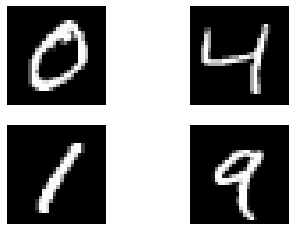

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

This chooses to use cuda cores if they are available. 
Using cuda cores means to use GPU acceleration, which dramatically reduces training time.

In [ ]:
# switch to False to use CPU
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

# Model and shared functions

The model utilises 3 convolutional layers and 2 fully contected layers

In [ ]:
class Net(nn.Module):
    def __init__(self):
        # this function creates the layers to bee used
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # this function connects the layers
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

These are the train and test functions used by some models

In [ ]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

This function permutes, or rearranges the pixels of every image in the dataset in the same way, this creates a new task for the model, as the learning for the unmodified dataset is not relevant to classifying the new images.

In [ ]:
def permute_mnist(mnist, seed):
    """ Given the training set, permute pixels of each img the same way. """

    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

This final set of functions can be used to measure training times for each epoch and for the train as a whole.

In [ ]:
# https://stackoverflow.com/a/55492933
import time

class TimeHistory():
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

timer = TimeHistory()

# Traditional Strategy

## NI (new instances)

When new instances are added to the dataset there is more data to work with, more training data can potentially increase the accuracy of the model.   
This new data though usually means that the model has to be retrained from scratch, which can be a long process, and requires bringing up the *entire* dataset again.

In [ ]:
def train(model, device, x_train, t_train, optimizer, epoch, timer):
    timer.on_epoch_begin(1)
    model.train()
    timer.on_epoch_end(1)
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    return loss.item()

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return test_loss, 100. * correct / len(t_test)

In [ ]:
dataset_increments = 10 # refers to the number of different levels of data that are tested to show the difference between models
x_size = len(x_train)
t_size = len(t_train)

DATA_NI_MODEL = {}
for i in range (1,dataset_increments): 
      print(x_size * (1 / dataset_increments) * i)
      DATA_NI_MODEL[i] = {}

      x = x_train[:int(x_size * (1 / dataset_increments) * i)]
      t = t_train[:int(x_size * (1 / dataset_increments) * i)]

      model = Net().to(device)
      optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

      timer.on_train_begin()
      for epoch in range(1, 4):
          train_loss = train(model, device, x, t, optimizer, epoch, timer)
          loss, acc = test(model, device, x_test, t_test)
          DATA_NI_MODEL[i][epoch] = {
              "train_loss" : train_loss,
              "loss" : loss,
              "acc" : acc
          }

      timeCount = np.average(timer.times) * 10000
      DATA_NI_MODEL[i]["time"] = timeCount
      print("Time: " + str(timeCount))
print(DATA_NI_MODEL)

6000.0
Train Epoch: 1 	Loss: 2.292454
Test set: Average loss: 0.0092, Accuracy: 1195/10000 (12%)

Train Epoch: 2 	Loss: 2.266730
Test set: Average loss: 0.0090, Accuracy: 2212/10000 (22%)

Train Epoch: 3 	Loss: 2.139745
Test set: Average loss: 0.0082, Accuracy: 4299/10000 (43%)

Time: 0.40133794148763025
12000.0
Train Epoch: 1 	Loss: 2.275947
Test set: Average loss: 0.0091, Accuracy: 2961/10000 (30%)

Train Epoch: 2 	Loss: 1.989419
Test set: Average loss: 0.0074, Accuracy: 4857/10000 (49%)

Train Epoch: 3 	Loss: 1.111719
Test set: Average loss: 0.0028, Accuracy: 7990/10000 (80%)

Time: 0.3544489542643229
18000.0
Train Epoch: 1 	Loss: 2.270383
Test set: Average loss: 0.0091, Accuracy: 2660/10000 (27%)

Train Epoch: 2 	Loss: 1.341165
Test set: Average loss: 0.0042, Accuracy: 7428/10000 (74%)

Train Epoch: 3 	Loss: 0.678102
Test set: Average loss: 0.0017, Accuracy: 8761/10000 (88%)

Time: 0.35365422566731775
24000.0
Train Epoch: 1 	Loss: 1.993967
Test set: Average loss: 0.0070, Accuracy: 

This can be allieviated by remembering the weights in the model and continuing training from where it was left off   
this method has its own drawback of potentially leading to overfitting

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

dataset_increments = 5 # refers to the number of different levels of data that are tested to show the difference between models
x_size = len(x_train)
t_size = len(t_train)

for i in range (1,dataset_increments): 
      print(x_size * (1 / dataset_increments) * i)

      x = x_train[:int(x_size * (1 / dataset_increments) * i)]
      t = t_train[:int(x_size * (1 / dataset_increments) * i)]

      timer.on_train_begin()
      for epoch in range(1, 4):
          train(model, device, x, t, optimizer, epoch, timer)
          test(model, device, x_test, t_test)

      timeCount = np.average(timer.times) * 10000
      print("Time: " + str(timeCount))

12000.0
Train Epoch: 1 	Loss: 2.253037
Test set: Average loss: 0.0089, Accuracy: 4987/10000 (50%)

Train Epoch: 2 	Loss: 1.588302
Test set: Average loss: 0.0050, Accuracy: 6625/10000 (66%)

Train Epoch: 3 	Loss: 0.887106
Test set: Average loss: 0.0024, Accuracy: 8217/10000 (82%)

Time: 0.49591064453125
24000.0
Train Epoch: 1 	Loss: 0.621161
Test set: Average loss: 0.0014, Accuracy: 8932/10000 (89%)

Train Epoch: 2 	Loss: 0.488525
Test set: Average loss: 0.0010, Accuracy: 9223/10000 (92%)

Train Epoch: 3 	Loss: 0.465255
Test set: Average loss: 0.0009, Accuracy: 9312/10000 (93%)

Time: 0.4140535990397135
36000.0
Train Epoch: 1 	Loss: 0.350922
Test set: Average loss: 0.0006, Accuracy: 9509/10000 (95%)

Train Epoch: 2 	Loss: 0.259530
Test set: Average loss: 0.0005, Accuracy: 9575/10000 (96%)

Train Epoch: 3 	Loss: 0.353961
Test set: Average loss: 0.0005, Accuracy: 9619/10000 (96%)

Time: 0.48955281575520837
48000.0
Train Epoch: 1 	Loss: 0.507824
Test set: Average loss: 0.0004, Accuracy: 96

## New Task

If the model were to be trained for a new task, training the model with this additional data to a satisfactory standard can mean that the model is less effective in classifying the previously trained data.

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

timer.on_train_begin()
for epoch in range(1, 4):
    train(model, device, x_train, t_train, optimizer, epoch, timer)
    test(model, device, x_test, t_test)

test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.676115
Test set: Average loss: 0.0012, Accuracy: 9046/10000 (90%)

Train Epoch: 2 	Loss: 0.637049
Test set: Average loss: 0.0007, Accuracy: 9475/10000 (95%)

Train Epoch: 3 	Loss: 0.459596
Test set: Average loss: 0.0005, Accuracy: 9585/10000 (96%)

Test set: Average loss: 0.0005, Accuracy: 9585/10000 (96%)



(0.0004988463742192834, 95.85)

An accuracy value can be achieved by testing the model

In [ ]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)

timer.on_train_begin()
for epoch in range(1, 4):
    train(model, device, x_train2, t_train, optimizer, epoch, timer)
    test(model, device, x_test, t_test)

test(model, device, x_test2, t_test)

starting permutation...
done.
Train Epoch: 1 	Loss: 1.581925
Test set: Average loss: 0.0176, Accuracy: 1853/10000 (19%)

Train Epoch: 2 	Loss: 1.219720
Test set: Average loss: 0.0249, Accuracy: 1554/10000 (16%)

Train Epoch: 3 	Loss: 1.117955
Test set: Average loss: 0.0242, Accuracy: 1565/10000 (16%)

Test set: Average loss: 0.0020, Accuracy: 8491/10000 (85%)



(0.001982059819996357, 84.91)

Training the model for the additional task and testing on the new task gives a new value for the test

In [ ]:
test(model, device, x_test, t_test)

Test set: Average loss: 0.0242, Accuracy: 1565/10000 (16%)



(0.024163356494903563, 15.65)

The old test has a lower accuracy value than before

# CL Strategies

To effectively learn continuously, the forgetting of previous tasks demonstrateed in Traditional machine learning strategies, called catastrophic forgetting, needs to be mitigated. The following are methods of mitigating catastophic forgetting, by modifying how the existing model updates its weights.

1.   Naive
2.   Rehearsal
3.   Elastic Weight Consolidation (EWC)
4.   Synaptic Intelligence (SI)

Each method will be testsed using 3 tasks made from Permuted MNIST.

Starting with defining the 3 tasks using the permute_mnist() function.



In [ ]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


## Naive / Traditional

In Continuous Learning settings, the standard way to refer to a model that does not continuously learn is "naive".
The naive strategy, as already demonstrated, is simply to train on new tasks, and, as demonstrated, is extremely prone to forgetting.

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
dataset_increments = 10 # refers to the number of different levels of data that are tested to show the difference between models
x_size = len(x_train)
t_size = len(t_train)

DATA_NAIVE_MODEL = {}
for i in range (1,dataset_increments): 
      print(x_size * (1 / dataset_increments) * i)
      DATA_NAIVE_MODEL[i] = {}

      for id, task in enumerate(tasks):
        print("Training on task: ", id)
        DATA_NAIVE_MODEL[i][id] ={}

        (x_train, t_train), (x_test, t_test) = task

        x = x_train[:int(x_size * (1 / dataset_increments) * i)]
        t = t_train[:int(x_size * (1 / dataset_increments) * i)]

        timer.on_train_begin()
        for epoch in range(1, 4):
              train_loss = train(model, device, x, t, optimizer, epoch, timer)

              loss, acc = test(model, device, x_test, t_test)

              DATA_NAIVE_MODEL[i][id][epoch] = {
                  "train_loss" : train_loss,
                  "loss" : loss,
                  "acc" : acc
              }

        timeCount = np.average(timer.times) * 10000
        DATA_NAIVE_MODEL[i][id]["time"] = timeCount
        print("Time: " + str(timeCount))
print(DATA_NAIVE_MODEL)  

6000.0
Training on task:  0
Train Epoch: 1 	Loss: 2.290832
Test set: Average loss: 0.0090, Accuracy: 3706/10000 (37%)

Train Epoch: 2 	Loss: 2.161490
Test set: Average loss: 0.0084, Accuracy: 4743/10000 (47%)

Train Epoch: 3 	Loss: 1.733964
Test set: Average loss: 0.0058, Accuracy: 6804/10000 (68%)

Time: 0.4116694132486979
Training on task:  1
Train Epoch: 1 	Loss: 2.287619
Test set: Average loss: 0.0091, Accuracy: 2046/10000 (20%)

Train Epoch: 2 	Loss: 2.186311
Test set: Average loss: 0.0088, Accuracy: 2890/10000 (29%)

Train Epoch: 3 	Loss: 2.172372
Test set: Average loss: 0.0083, Accuracy: 3437/10000 (34%)

Time: 0.39180119832356775
Training on task:  2
Train Epoch: 1 	Loss: 2.163676
Test set: Average loss: 0.0085, Accuracy: 3074/10000 (31%)

Train Epoch: 2 	Loss: 2.003976
Test set: Average loss: 0.0078, Accuracy: 3682/10000 (37%)

Train Epoch: 3 	Loss: 1.881421
Test set: Average loss: 0.0070, Accuracy: 4463/10000 (45%)

Time: 0.404516855875651
12000.0
Training on task:  0
Train E

In [ ]:
DATA_NAIVE_MODEL["final_accs"] = {}
accs = []
for id, task in enumerate(tasks):
  _, (x_test, t_test) = task
  _, acc = test(model, device, x_test, t_test)
  accs.append(acc)
  DATA_NAIVE_MODEL["final_accs"][id] = acc

DATA_NAIVE_MODEL["final_accs"]["avg"] = np.average(accs)

Test set: Average loss: 0.0049, Accuracy: 6096/10000 (61%)

Test set: Average loss: 0.0049, Accuracy: 5928/10000 (59%)

Test set: Average loss: 0.0013, Accuracy: 8980/10000 (90%)



## Rehearsal Strategy

A simple CL idea is to retrain or *rehearse* some or all of the previously encountered examples (of the previous tasks), shuffling them with the data of the current task. Using *all* the past data is near to the optimal performance we can desire at the end of the task sequence but at the expense of much bigger memory usage.

Start with a function to shuffle past data into current training set.



In [ ]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

Reset model and optimiser.

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
dataset_increments = 10 # refers to the number of different levels of data that are tested to show the difference between models
x_size = len(x_train)
t_size = len(t_train)

DATA_REHEARSE_MODEL = {}
for i in range (1,dataset_increments): 
      print(x_size * (1 / dataset_increments) * i)
      DATA_REHEARSE_MODEL[i] = {}

      for id, task in enumerate(tasks):
        print("Training on task: ", id)
        DATA_REHEARSE_MODEL[i][id] = {}
        
        (x_train, t_train), (x_test, t_test) = task

        x = x_train[:int(x_size * (1 / dataset_increments) * i)]
        t = t_train[:int(x_size * (1 / dataset_increments) * i)]
        
        # for previous task
        for j in range(id):
          (past_x_train, past_t_train), _ = tasks[j]
          x = np.concatenate((x, past_x_train))
          t = np.concatenate((t, past_t_train))
        
        x, t = shuffle_in_unison([x_train, t_train], 0)

        timer.on_train_begin()
        for epoch in range(1, 4):
              train_loss = train(model, device, x, t, optimizer, epoch, timer)

              loss, acc = test(model, device, x_test, t_test)

              DATA_REHEARSE_MODEL[i][id][epoch] = {
                  "train_loss" : train_loss,
                  "loss" : loss,
                  "acc" : acc
              }

        timeCount = np.average(timer.times) * 10000
        DATA_REHEARSE_MODEL[i][id]["time"] = timeCount
        print("Time: " + str(timeCount))
print(DATA_REHEARSE_MODEL) 


6000.0
Training on task:  0
Train Epoch: 1 	Loss: 0.627441
Test set: Average loss: 0.0012, Accuracy: 9146/10000 (91%)

Train Epoch: 2 	Loss: 0.448485
Test set: Average loss: 0.0007, Accuracy: 9474/10000 (95%)

Train Epoch: 3 	Loss: 0.273114
Test set: Average loss: 0.0005, Accuracy: 9577/10000 (96%)

Time: 0.5245208740234375
Training on task:  1
Train Epoch: 1 	Loss: 1.552298
Test set: Average loss: 0.0050, Accuracy: 6539/10000 (65%)

Train Epoch: 2 	Loss: 1.194747
Test set: Average loss: 0.0031, Accuracy: 7723/10000 (77%)

Train Epoch: 3 	Loss: 0.939780
Test set: Average loss: 0.0024, Accuracy: 8289/10000 (83%)

Time: 0.5396207173665365
Training on task:  2
Train Epoch: 1 	Loss: 1.393832
Test set: Average loss: 0.0044, Accuracy: 6807/10000 (68%)

Train Epoch: 2 	Loss: 0.967356
Test set: Average loss: 0.0027, Accuracy: 8057/10000 (81%)

Train Epoch: 3 	Loss: 0.908479
Test set: Average loss: 0.0022, Accuracy: 8421/10000 (84%)

Time: 0.530083974202474
12000.0
Training on task:  0
Train Ep

In [ ]:
DATA_REHEARSE_MODEL["final_accs"] = {}
accs = []
for id, task in enumerate(tasks):
  _, (x_test, t_test) = task
  _, acc = test(model, device, x_test, t_test)
  accs.append(acc)
  DATA_REHEARSE_MODEL["final_accs"][id] = acc

DATA_REHEARSE_MODEL["final_accs"]["avg"] = np.average(accs)

Test set: Average loss: 0.0043, Accuracy: 6514/10000 (65%)

Test set: Average loss: 0.0041, Accuracy: 6653/10000 (67%)

Test set: Average loss: 0.0011, Accuracy: 9159/10000 (92%)



# CL Strategies - Weight modification

A more advanced method of mitigating CF is to modify how the weights in the model are trained, changing weight training methods during training can dramatically impact how weights are used and optimise each weight individually.   

Weight modification strategies benefit from a normalised dataset, as loss values can become extremely large and unmanagable without this normalisation.

In [ ]:
x_train = (x_train - x_train.min())/(x_train.max() - x_train.min())
t_train = (t_train - t_train.min())/(t_train.max() - t_train.min())

## Elastic Weight consolidation

Initially proposed in ["Overcoming catastrophic forgetting in neural networks"](https://doi.org/10.1073/pnas.1611835114) Elastic Weight Consolidation helps to remember the training for older tasks by finding which weights are important for that task and slowing the training of those weights, little change in these weights means that the accuracy of the task they contribute to will be similar on revisit.

In [ ]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Define a method to measure and log the gradients and fisher matrices, these are useful for the training proess as they define how much to train each weight for a given task

In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

EWC requires a special training function that includes the weight modification strategy.

In [ ]:
def trainEWC(model, device, task_id, x_train, t_train, optimizer, epoch, timer):
    timer.on_epoch_begin(1)
    model.train()
    timer.on_epoch_end(1)
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)

      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2) * 0.0001).sum() * ewc_lambda

      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    return loss.item()

def testEWC(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return test_loss, 100. * correct / len(t_test)

This section begins to train and gather data on the EWC strategy, trying different sizes of dataset, timing and logging the loss and accuracy of each training session.

In [ ]:
dataset_increments = 10 # refers to the number of different levels of data that are tested to show the difference between models
x_size = len(x_train)
t_size = len(t_train)

DATA_EWC_MODEL = {}
for i in range (1,dataset_increments): 
      print(x_size * (1 / dataset_increments) * i)
      DATA_EWC_MODEL[i] = {}

      for id, task in enumerate(tasks):
          print("Training on task: ", id)
          DATA_EWC_MODEL[i][id] = {}

          (x_train, t_train), (x_test, t_test) = task

          x = x_train[:int(x_size * (1 / dataset_increments) * i)]
          t = t_train[:int(x_size * (1 / dataset_increments) * i)]

          timer.on_train_begin()
          for epoch in range(1, 4):
              train_loss = trainEWC(model, device, id, x, t, optimizer, epoch, timer)
              on_task_update(id, x, t)

              loss, acc = testEWC(model, device, x_test, t_test)

              DATA_EWC_MODEL[i][id][epoch] = {
                  "train_loss" : train_loss,
                  "loss" : loss,
                  "acc" : acc
              }

          timeCount = np.average(timer.times) * 10000
          DATA_EWC_MODEL[i][id]["time"] = timeCount
          print("Time: " + str(timeCount))
print(DATA_EWC_MODEL)

6000.0
Training on task:  0
Train Epoch: 1 	Loss: 2.301944
Test set: Average loss: 0.0092, Accuracy: 2181/10000 (22%)

Train Epoch: 2 	Loss: 2.263390
Test set: Average loss: 0.0090, Accuracy: 2893/10000 (29%)

Train Epoch: 3 	Loss: 2.108776
Test set: Average loss: 0.0082, Accuracy: 5101/10000 (51%)

Time: 0.4307428995768229
Training on task:  1
Train Epoch: 1 	Loss: 2.315231
Test set: Average loss: 0.0092, Accuracy: 1260/10000 (13%)

Train Epoch: 2 	Loss: 2.284775
Test set: Average loss: 0.0091, Accuracy: 2749/10000 (27%)

Train Epoch: 3 	Loss: 2.241757
Test set: Average loss: 0.0089, Accuracy: 2763/10000 (28%)

Time: 0.3552436828613281
Training on task:  2
Train Epoch: 1 	Loss: 2.243030
Test set: Average loss: 0.0089, Accuracy: 2283/10000 (23%)

Train Epoch: 2 	Loss: 2.182085
Test set: Average loss: 0.0087, Accuracy: 2783/10000 (28%)

Train Epoch: 3 	Loss: 2.163635
Test set: Average loss: 0.0084, Accuracy: 3298/10000 (33%)

Time: 0.42994817097981775
12000.0
Training on task:  0
Train 

In [ ]:
DATA_EWC_MODEL["final_accs"] = {}
accs = []
for id, task in enumerate(tasks):
  _, (x_test, t_test) = task
  _, acc = testEWC(model, device, x_test, t_test)
  accs.append(acc)
  DATA_EWC_MODEL["final_accs"][id] = acc

DATA_EWC_MODEL["final_accs"]["avg"] = np.average(accs)

Test set: Average loss: 0.0018, Accuracy: 8578/10000 (86%)

Test set: Average loss: 0.0033, Accuracy: 7350/10000 (74%)

Test set: Average loss: 0.0011, Accuracy: 9173/10000 (92%)



## Synaptic Intelligence (SI)

Proposed in ["Continual Learning Through Synaptic Intelligence"](http://proceedings.mlr.press/v70/zenke17a/zenke17a.pdf) as a variant of EWC.   
SI was introduced as an improvement on EWC because EWC uses fisher matrices for calculating the importance of a weight, which is not used by SI, potentially increasing its efficiency.

In [ ]:
optpar_dict = {}
ewc_lambda = 0.4
XI = 0.001 # a small constant to avoid divide by zero

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()
  
  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():
    
    optpar_dict[task_id][name] = param.data.clone()

In [ ]:
def trainSI(model, device, task_id, x_train, t_train, optimizer, epoch, timer):
    timer.on_epoch_begin(1)
    model.train()
    timer.on_epoch_end(1)
    
    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      
      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)
      DELTA_L = 0 # change in L
      batches = 10

      for task in range(task_id):
        for name, param in model.named_parameters():
          optpar = optpar_dict[task][name]
          TOTAL_DELTA_L = 0
          DELTA_THETA_K = optpar - param
          for batch in range(0,batches):
            if batch == 0:
              DELTA_L = ewc_lambda * (ewc_lambda * (optpar - param).pow(2)).sum()
            else:
              TK = DELTA_L # tk is the previous change in L
              DELTA_L = ewc_lambda * ( ( (TOTAL_DELTA_L).sum()  / ((TK).pow(2) + XI) ) * (DELTA_THETA_K).pow(2) * 0.0001).sum()   
              # this is the line that makes SI special, its similar to EWC
            TOTAL_DELTA_L += DELTA_L
          loss += TOTAL_DELTA_L

      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))
    return loss.item()

def testSI(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return test_loss, 100. * correct / len(t_test)

In [ ]:
dataset_increments = 10 # refers to the number of different levels of data that are tested to show the difference between models
x_size = len(x_train)
t_size = len(t_train)

DATA_SI_MODEL = {}
for i in range (1,dataset_increments): 
      print(x_size * (1 / dataset_increments) * i)
      DATA_SI_MODEL[i] = {}

      for id, task in enumerate(tasks):
          print("Training on task: ", id)
          DATA_SI_MODEL[i][id] = {}

          (x_train, t_train), (x_test, t_test) = task

          x = x_train[:int(x_size * (1 / dataset_increments) * i)]
          t = t_train[:int(x_size * (1 / dataset_increments) * i)]


          timer.on_train_begin()
          for epoch in range(1, 4):
              train_loss = trainSI(model, device, id, x, t, optimizer, epoch, timer)
              on_task_update(id, x, t)

              loss, acc = testSI(model, device, x_test, t_test)

              DATA_SI_MODEL[i][id][epoch] = {
                  "train_loss" : train_loss,
                  "loss" : loss,
                  "acc" : acc
              }

          timeCount = np.average(timer.times) * 10000
          DATA_SI_MODEL[i][id]["time"] = timeCount
          print("Time: " + str(timeCount))
print(DATA_SI_MODEL)

6000.0
Training on task:  0
Train Epoch: 1 	Loss: 2.288982
Test set: Average loss: 0.0092, Accuracy: 1845/10000 (18%)

Train Epoch: 2 	Loss: 2.260105
Test set: Average loss: 0.0090, Accuracy: 4247/10000 (42%)

Train Epoch: 3 	Loss: 2.197322
Test set: Average loss: 0.0085, Accuracy: 4303/10000 (43%)

Time: 0.7073084513346355
Training on task:  1
Train Epoch: 1 	Loss: 2.306656
Test set: Average loss: 0.0092, Accuracy: 1474/10000 (15%)

Train Epoch: 2 	Loss: 2.309240
Test set: Average loss: 0.0091, Accuracy: 1942/10000 (19%)

Train Epoch: 3 	Loss: 2.281035
Test set: Average loss: 0.0091, Accuracy: 2262/10000 (23%)

Time: 0.4251797993977865
Training on task:  2
Train Epoch: 1 	Loss: 2.300925
Test set: Average loss: 0.0091, Accuracy: 2017/10000 (20%)

Train Epoch: 2 	Loss: 2.287255
Test set: Average loss: 0.0091, Accuracy: 1982/10000 (20%)

Train Epoch: 3 	Loss: 2.297637
Test set: Average loss: 0.0091, Accuracy: 1819/10000 (18%)

Time: 0.4291534423828125
12000.0
Training on task:  0
Train E

In [ ]:
DATA_SI_MODEL["final_accs"] = {}
accs = []
for id, task in enumerate(tasks):
  _, (x_test, t_test) = task
  _, acc = testSI(model, device, x_test, t_test)
  accs.append(acc)
  DATA_SI_MODEL["final_accs"][id] = acc

DATA_SI_MODEL["final_accs"]["avg"] = np.average(accs)

Test set: Average loss: 0.0004, Accuracy: 9706/10000 (97%)

Test set: Average loss: 0.0067, Accuracy: 4065/10000 (41%)

Test set: Average loss: 0.0054, Accuracy: 6258/10000 (63%)



Train SI for only one task so that it can be directly compared to 'traditional' in an application that suits 'traditional'

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

dataset_increments = 10 # refers to the number of different levels of data that are tested to show the difference between models
x_size = len(x_train)
t_size = len(t_train)

DATA_SI_SIT_MODEL = {}
for i in range (1,dataset_increments): 
      print(x_size * (1 / dataset_increments) * i)
      DATA_SI_SIT_MODEL[i] = {}

      x = x_train[:int(x_size * (1 / dataset_increments) * i)]
      t = t_train[:int(x_size * (1 / dataset_increments) * i)]

      timer.on_train_begin()
      for epoch in range(1, 4):
          train_loss = trainSI(model, device, 0, x, t, optimizer, epoch, timer)

          loss, acc = testSI(model, device, x_test, t_test)

          DATA_SI_SIT_MODEL[i][epoch] = {
              "train_loss" : train_loss,
              "loss" : loss,
              "acc" : acc
          }

      timeCount = np.average(timer.times) * 10000
      DATA_SI_SIT_MODEL[i]["time"] = timeCount
      print("Time: " + str(timeCount))

6000.0
Train Epoch: 1 	Loss: 2.296127
Test set: Average loss: 0.0092, Accuracy: 980/10000 (10%)

Train Epoch: 2 	Loss: 2.298663
Test set: Average loss: 0.0092, Accuracy: 981/10000 (10%)

Train Epoch: 3 	Loss: 2.293697
Test set: Average loss: 0.0092, Accuracy: 2283/10000 (23%)

Time: 0.38226445515950525
12000.0
Train Epoch: 1 	Loss: 2.291453
Test set: Average loss: 0.0091, Accuracy: 3112/10000 (31%)

Train Epoch: 2 	Loss: 2.270966
Test set: Average loss: 0.0090, Accuracy: 2578/10000 (26%)

Train Epoch: 3 	Loss: 2.202689
Test set: Average loss: 0.0086, Accuracy: 3096/10000 (31%)

Time: 0.37272771199544275
18000.0
Train Epoch: 1 	Loss: 1.999080
Test set: Average loss: 0.0073, Accuracy: 4581/10000 (46%)

Train Epoch: 2 	Loss: 1.436518
Test set: Average loss: 0.0052, Accuracy: 6479/10000 (65%)

Train Epoch: 3 	Loss: 1.114424
Test set: Average loss: 0.0039, Accuracy: 7252/10000 (73%)

Time: 0.5062421162923177
24000.0
Train Epoch: 1 	Loss: 1.045286
Test set: Average loss: 0.0029, Accuracy: 79

# Plot Results

To conclude, let's summerize our results in a nice plot! :-)

In [ ]:
import json

print("ni")
print(json.dumps(DATA_NI_MODEL, indent=4))
print("naive")
print(json.dumps(DATA_NAIVE_MODEL, indent=4))
print("rehearse")
print(json.dumps(DATA_REHEARSE_MODEL, indent=4))
print("ewc")
print(json.dumps(DATA_EWC_MODEL, indent=4))
print("si")
print(json.dumps(DATA_SI_MODEL, indent=4))
DATA = { 
    "NAIVE" : DATA_NAIVE_MODEL, 
    "REHEARSAL" : DATA_REHEARSE_MODEL, 
    "EWC" : DATA_EWC_MODEL, 
    "SI" : DATA_SI_MODEL
}

DATA_SIT = {
    "NI" : DATA_NI_MODEL,
    "SI" : DATA_SI_SIT_MODEL
}

ni
{
    "1": {
        "1": {
            "train_loss": 2.2924535274505615,
            "loss": 0.00916756467819214,
            "acc": 11.95
        },
        "2": {
            "train_loss": 2.2667300701141357,
            "loss": 0.009016350555419921,
            "acc": 22.12
        },
        "3": {
            "train_loss": 2.1397452354431152,
            "loss": 0.008185567760467529,
            "acc": 42.99
        },
        "time": 0.40133794148763025
    },
    "2": {
        "1": {
            "train_loss": 2.275947093963623,
            "loss": 0.009090036582946777,
            "acc": 29.61
        },
        "2": {
            "train_loss": 1.9894192218780518,
            "loss": 0.007368216109275818,
            "acc": 48.57
        },
        "3": {
            "train_loss": 1.111718773841858,
            "loss": 0.0027832350075244904,
            "acc": 79.9
        },
        "time": 0.3544489542643229
    },
    "3": {
        "1": {
            "train_loss": 2.270

In [ ]:
names = tuple([key for key in DATA])

dataset_increments = range(1,10)
task_count = range(0,3)
epochs = range(1,4)

metrics = DATA[names[0]][dataset_increments[0]][task_count[0]][epochs[0]].keys()
metrics = tuple([key for key in metrics])

sit_names = tuple([key for key in DATA_SIT])
sit_metrics = DATA_SIT[sit_names[0]][dataset_increments[0]][epochs[0]].keys()
sit_metrics = tuple([key for key in sit_metrics])

In [ ]:
for metric in metrics:
  for dataset_increment in dataset_increments:
    for task_id in task_count:
      plt.figure()
      for name in names:
        y = []
        for epoch in epochs:
          y.append(DATA[name][dataset_increment][task_id][epoch][metric])
        plt.plot(epochs, y, label=name)

      plt.xlabel('Epoch number', fontsize=14)
      plt.ylabel(metric, fontsize=14)
      plt.title('{} by Epoch number for task {} datasize {}'.format(metric, task_id + 1, dataset_increment), fontsize=14)
      plt.xticks(epochs)
      plt.legend(prop={'size': 16})

In [ ]:
for metric in metrics:
  for dataset_increment in dataset_increments:
    plt.figure()
    for name in names:
      y = []
      for task_id in task_count:
        metric_data = []
        for epoch in epochs:
          metric_data.append(DATA[name][dataset_increment][task_id][epoch][metric])

        y.append(np.average(metric_data))

      plt.plot([task for task in task_count], y, label=name)

      plt.xlabel('Task number', fontsize=14)
      plt.ylabel(metric, fontsize=14)
      plt.title('{} by task number for datasize {}'.format(metric, dataset_increment), fontsize=14)
      plt.xticks(task_count)
      plt.legend(prop={'size': 16})

In [ ]:
for dataset_increment in dataset_increments:
  plt.figure()
  for name in names:
    y = []
    for task_id in task_count:
      metric_data = []
      for epoch in epochs:
        metric_data.append(DATA[name][dataset_increment][task_id]["time"])

      y.append(np.average(metric_data))

    plt.plot([task for task in task_count], y, label=name)

    plt.xlabel('Task number', fontsize=14)
    plt.ylabel("Training time", fontsize=14)
    plt.title('Training time by task number for datasize {}'.format(dataset_increment), fontsize=14)
    plt.xticks(task_count)
    plt.legend(prop={'size': 16})

Data for test NI model against SI trained for single incremental task (SIT) for fair comparison.

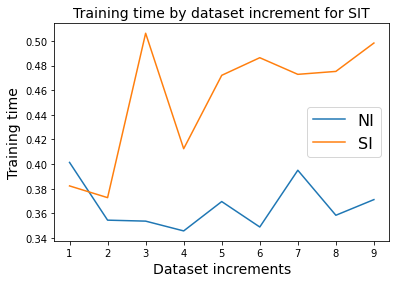

In [ ]:
plt.figure()
for name in sit_names:
  y = []
  for dataset_increment in dataset_increments:
    y.append(DATA_SIT[name][dataset_increment]['time'])

  plt.plot([dataset_increment for dataset_increment in dataset_increments], y, label=name)

  plt.xlabel('Dataset increments', fontsize=14)
  plt.ylabel("Training time", fontsize=14)
  plt.title('Training time by dataset increment for SIT', fontsize=14)
  plt.xticks(dataset_increments)
  plt.legend(prop={'size': 16})

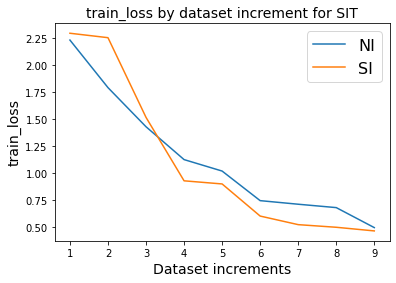

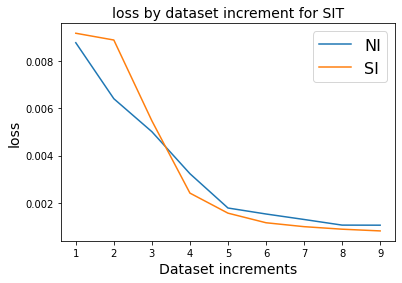

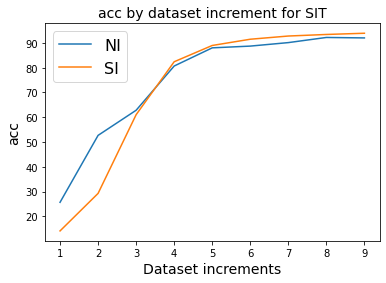

In [ ]:
for metric in sit_metrics:
  plt.figure()
  for name in sit_names:
    y = []
    for dataset_increment in dataset_increments:
        metric_data = []
        for epoch in epochs:
          metric_data.append(DATA_SIT[name][dataset_increment][epoch][metric])

        y.append(np.average(metric_data))

    plt.plot([dataset_increment for dataset_increment in dataset_increments], y, label=name)

    plt.xlabel('Dataset increments', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.title('{} by dataset increment for SIT'.format(metric), fontsize=14)
    plt.xticks(dataset_increments)
    plt.legend(prop={'size': 16})

# Error Testing

Testing timings of python dict to determine the approximate error percentage

In [ ]:
import timeit

timeit.repeat("tmp[0]=True; x=tmp[0]", 
              "tmp={};", 
              number=100000
              )

[0.007472937999978058,
 0.008721429999980046,
 0.007410044999971888,
 0.007513603999996121,
 0.007675511000002189]